<a href="https://colab.research.google.com/github/parkmicheal1114/Python_Quest/blob/main/MainQuest/Exploration_CR4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import Library

In [1]:
import numpy as np
import sys
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D , BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds

In [2]:
tfds.__version__

'4.9.2'

# tfds Dataset Load

- 참조 사이트
  - https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=ko
  - https://www.tensorflow.org/datasets/overview?hl=ko



In [3]:
# tfds.list_builders() => 데이터셋 목록
(ds_train  , ds_val , ds_test) , ds_meta  = tfds.load(
      name = 'cats_vs_dogs' ,
      split = ['train[:70%]' ,'train[70%:90%]' ,'train[90%:]'],
      data_dir = './cats_vs_dogs',
      download = True,
      shuffle_files=True,
      with_info= True, # 메타데이터 포함된 데이터 셋.
      as_supervised= True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs/cats_vs_dogs/4.0.0.incompleteHK97J9/cats_vs_dogs-train.tfrecord*...:   0%|          | 0…

Dataset cats_vs_dogs downloaded and prepared to ./cats_vs_dogs/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
print(ds_train)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [5]:
def image(ds):
  plt.figure(figsize=(10,5))
  labels = ds_meta.features['label'].int2str
  for idx, (image, label) in enumerate(ds.take(10)):  # 10개의 데이터를 가져 옵니다.
      plt.subplot(2, 5, idx+1)
      plt.imshow(image)
      plt.title(f'label {label}: {labels(label)}')
      plt.axis('off')

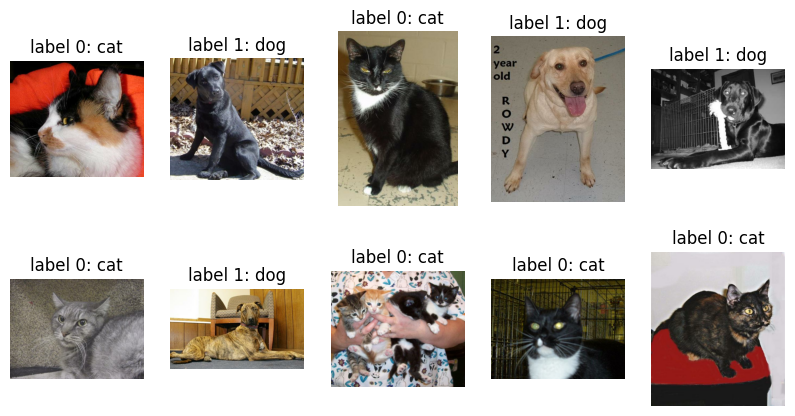

In [6]:
image(ds_train)

# Data Preprocessing

In [7]:
IMG_SIZE = 256 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/255.) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [8]:
train = ds_train.map(format_example)
validation = ds_val.map(format_example)
test = ds_test.map(format_example)

In [9]:
def scaled_image(ds):
  plt.figure(figsize=(10,5))
  labels = ds_meta.features['label'].int2str
  for idx, (image, label) in enumerate(ds.take(10)):  # 10개의 데이터를 가져 옵니다.
      plt.subplot(2, 5, idx+1)
      image = (image+1)/2
      plt.imshow(image)
      plt.title(f'label {label}: {labels(label)}')
      plt.axis('off')

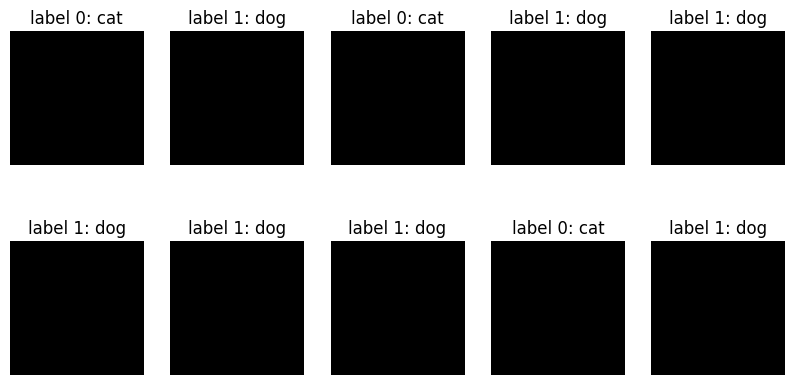

In [10]:
image(train)
# scale 을 255. 으로 하게 되면 imshow 에서 range 경고가 나옴,,, 하지만 이미지 사이즈는 모두 균일하게 정리 되었음.
# 현재 이미지는 127.5로 했을때 화질이며 , scale 은 255. 로 우선 시도 하였음.

image  label
0  [[[242, 248, 248], [240, 246, 246], [235, 239,...      1
1  [[[215, 165, 114], [187, 135, 85], [232, 176, ...      1
2  [[[177, 183, 157], [185, 191, 165], [192, 198,...      1
3  [[[92, 66, 7], [93, 67, 8], [93, 67, 8], [93, ...      0
4  [[[140, 138, 141], [140, 138, 141], [141, 139,...      1
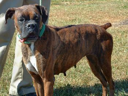
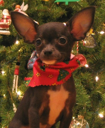
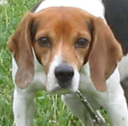
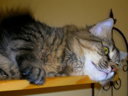
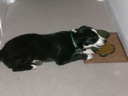

In [11]:
# 데이터 셋 df 형태로 볼수 있게.(train data 는 array 형태로 바뀌었음.)
tfds.as_dataframe(ds_train.take(5) , ds_meta)

# Model Build

## Batch.

In [12]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [13]:
# batch test
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 256, 256, 3]), TensorShape([32]))

## CallBack

In [14]:
from keras.callbacks import EarlyStopping , ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='min')

callbacks = [early_stopping, reduce_lr]

# VGG16 TEST  
  - FC만 세팅 하여 학습

In [15]:
from keras.applications import VGG16

# VGG16 모델 불러오기
vgg16 = VGG16(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights="imagenet")

# 모든 층을 고정
for layer in vgg16.layers:
    layer.trainable = False

# FC Layer 추가하기
model = Sequential()
model.add(vgg16)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))


model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])



58889256/58889256 [==============================] - 1s 0us/step


In [16]:
feature_batch = model(image_batch)
feature_batch.shape

TensorShape([32, 2])

In [17]:
EPOCHS = 10

history = model.fit(
  train_batches,
  batch_size = BATCH_SIZE,
  epochs=EPOCHS,
  callbacks = callbacks,
  validation_data= validation_batches)

Epoch 1/10
509/509 [==============================] - 127s 230ms/step - loss: 0.4066 - accuracy: 0.8515 - val_loss: 0.2908 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 2/10
509/509 [==============================] - 110s 213ms/step - loss: 0.2522 - accuracy: 0.9062 - val_loss: 0.2197 - val_accuracy: 0.9132 - lr: 1.0000e-04
Epoch 3/10
509/509 [==============================] - 111s 213ms/step - loss: 0.2140 - accuracy: 0.9165 - val_loss: 0.1938 - val_accuracy: 0.9235 - lr: 1.0000e-04
Epoch 4/10
509/509 [==============================] - 110s 212ms/step - loss: 0.1958 - accuracy: 0.9246 - val_loss: 0.1787 - val_accuracy: 0.9282 - lr: 1.0000e-04
Epoch 5/10
509/509 [==============================] - 127s 247ms/step - loss: 0.1845 - accuracy: 0.9272 - val_loss: 0.1695 - val_accuracy: 0.9308 - lr: 1.0000e-04
Epoch 6/10
509/509 [==============================] - 128s 247ms/step - loss: 0.1767 - accuracy: 0.9290 - val_loss: 0.1698 - val_accuracy: 0.9321 - lr: 1.0000e-04
Epoch 7/10
509/509 [==

## Accuracy & Loss

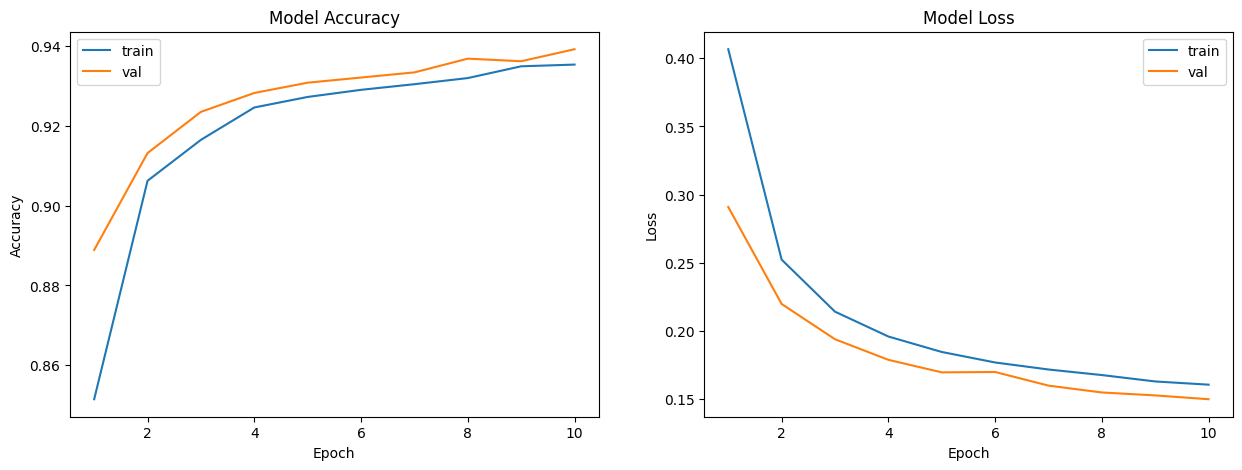

In [18]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))

    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')

    axs[0].legend(['train', 'val'], loc='best')

    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')

    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(history)

## Evaluate & Prediction

In [20]:
model.evaluate(validation_batches, steps = 20 , verbose = 2)

20/20 - 4s - loss: 0.1319 - accuracy: 0.9453 - 4s/epoch - 180ms/step


[0.13194647431373596, 0.9453125]

In [30]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 33ms/step


In [31]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)

93.75


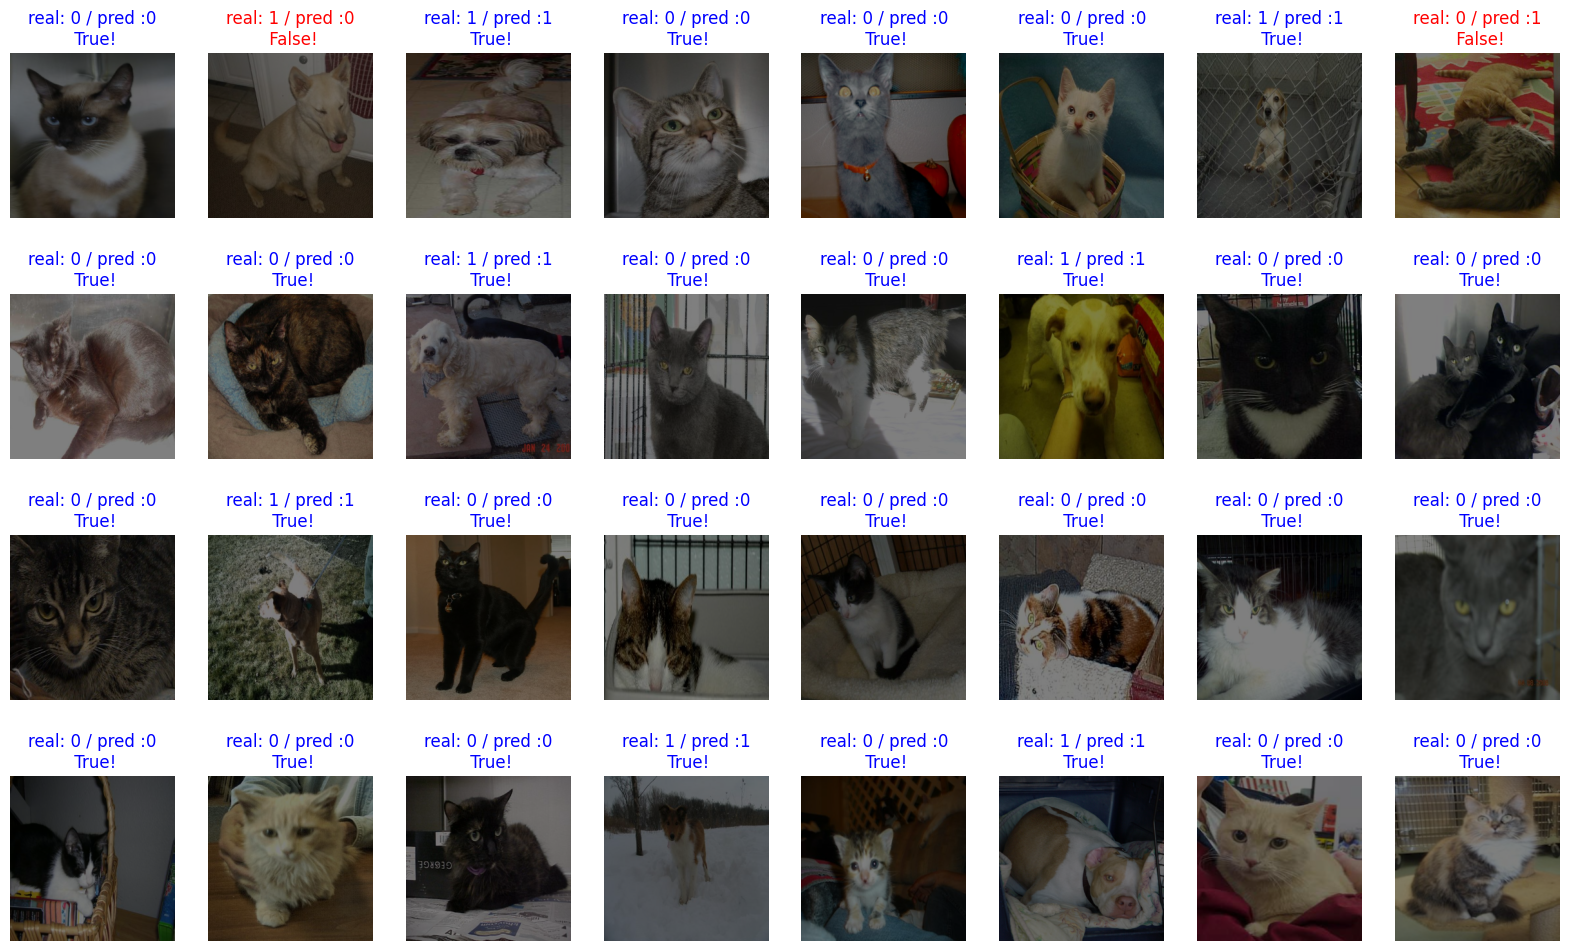

In [34]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

# VGG16 ( Fine Tuning)

In [41]:
# Freezing 할 레이어 화인
for idx , block in enumerate(vgg16.layers):
  print (idx , block)

0 <keras.engine.input_layer.InputLayer object at 0x7c5f8cc03220>
1 <keras.layers.convolutional.conv2d.Conv2D object at 0x7c5f8cc01f90>
2 <keras.layers.convolutional.conv2d.Conv2D object at 0x7c5f90b22080>
3 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7c5f90bef250>
4 <keras.layers.convolutional.conv2d.Conv2D object at 0x7c5f90bef1f0>
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x7c5f8cc28ee0>
6 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7c5f8cc2a380>
7 <keras.layers.convolutional.conv2d.Conv2D object at 0x7c6010761390>
8 <keras.layers.convolutional.conv2d.Conv2D object at 0x7c5f8cc2acb0>
9 <keras.layers.convolutional.conv2d.Conv2D object at 0x7c5f8cc2b700>
10 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7c5f8cc2a800>
11 <keras.layers.convolutional.conv2d.Conv2D object at 0x7c5f8cc2a9b0>
12 <keras.layers.convolutional.conv2d.Conv2D object at 0x7c5f90d55fc0>
13 <keras.layers.convolutional.conv2d.Conv2D object at 0x7c5f8cc2ac50>


In [42]:
# VGG16 모델 불러오기
vgg16 = VGG16(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights="imagenet")

# freeze_index 설정하기
freeze_index = 15 # block5_conv1 레이어의 인덱스

# freeze_index 이전의 층은 고정하고, 이후의 층은 학습 가능하게 설정하기
for layer in vgg16.layers[:freeze_index]:
    layer.trainable = False
for layer in vgg16.layers[freeze_index:]:
    layer.trainable = True


# FC Layer 추가하기
model = Sequential()
model.add(vgg16)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))


model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

In [43]:
EPOCHS = 5

history = model.fit(
  train_batches,
  batch_size = BATCH_SIZE,
  epochs=EPOCHS,
  callbacks = callbacks,
  validation_data= validation_batches)

Epoch 1/5
509/509 [==============================] - 127s 239ms/step - loss: 0.1906 - accuracy: 0.9181 - val_loss: 0.3125 - val_accuracy: 0.8973 - lr: 1.0000e-04
Epoch 2/5
509/509 [==============================] - 123s 238ms/step - loss: 0.0888 - accuracy: 0.9662 - val_loss: 0.1214 - val_accuracy: 0.9525 - lr: 1.0000e-04
Epoch 3/5
509/509 [==============================] - 122s 236ms/step - loss: 0.0613 - accuracy: 0.9764 - val_loss: 0.0807 - val_accuracy: 0.9729 - lr: 1.0000e-04
Epoch 4/5
509/509 [==============================] - 140s 271ms/step - loss: 0.0422 - accuracy: 0.9848 - val_loss: 0.0715 - val_accuracy: 0.9714 - lr: 1.0000e-04
Epoch 5/5
509/509 [==============================] - 122s 236ms/step - loss: 0.0282 - accuracy: 0.9911 - val_loss: 0.0884 - val_accuracy: 0.9731 - lr: 1.0000e-04


In [44]:
model.evaluate(validation_batches, steps = 20 , verbose = 2)

20/20 - 3s - loss: 0.0806 - accuracy: 0.9797 - 3s/epoch - 168ms/step


[0.08058251440525055, 0.979687511920929]

In [45]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions = np.argmax(predictions, axis=1)

count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)

1/1 [==============================] - 0s 161ms/step
96.875


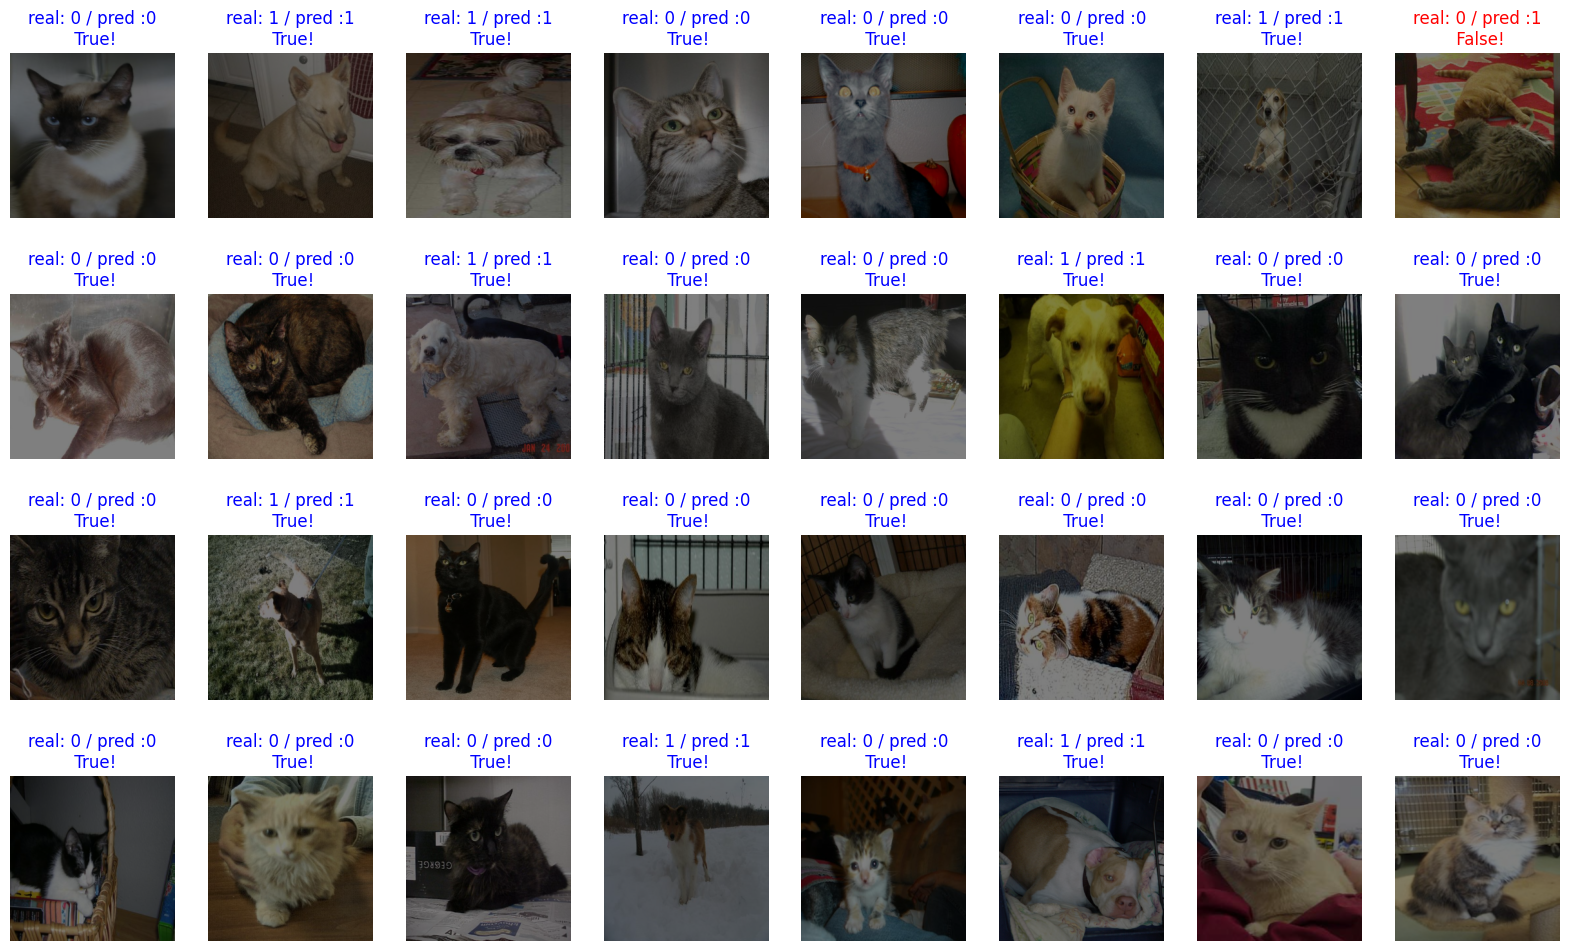

In [46]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

# Conclusion

- 이번 Node 를 진행하면서 DLthon 에서 Predict Layer Activation 과 loss function 에 대한 아쉬움이 남는다. 이렇게 배웠다고 생각한다.!!!!

- VGG16 으로 2가지 테스트를 진행 했다 . 하나는 VGG16 을 Fine tuning 하지 않고 사용 했을 떄와 , block 5 Layer 부터 학습을 활성 화 시키고 사용 했을때 2가지 경우 였다.

 - Fine Tuning 하지 않은 경우 : precdict 의 정확도 ( 93.75 % )
 - Fine Tuning 을 block5 에서 진행 한 경우 : precdict 의 정확도 ( 96.875 % )

 - 다만 Epoch 에서 차이가 있어서 정확한 실험이다라고 평가 하기는 어렵지만 , 데이터셋 이 20,000장 이상 인지라 확실히 Tuning 을 하고 안하고의 차이는 명확하게 보이는 것 같다.

 - Tuning 을 한 Model은 동물의 얼굴이 안보이는 이미지를 제외 하고는 모두 정확하게 판별 하고 있음을 알 수 있다.

# Model Save

In [48]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/model_save/cat_dog')

# Applicate

In [52]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_SIZE = 256
image_path = '/content/drive/MyDrive/Colab Notebooks/aiffel/cat.jpg'

# 이미지 처리
image = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
image = img_to_array(image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
image.shape

(1, 256, 256, 3)

In [53]:
prediction = model.predict(image)
prediction

1/1 [==============================] - 0s 62ms/step


array([[0., 1.]], dtype=float32)

In [56]:
def show_and_predict_image(dirpath, filename, img_size=256):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    cat_percentage = round(prediction[0] * 100)
    dog_percentage = round(prediction[1] * 100)
    print(f"This image seems {dog_percentage}% dog, and {cat_percentage}% cat.")

1/1 [==============================] - 1s 679ms/step
This image seems 100% dog, and 0% cat.


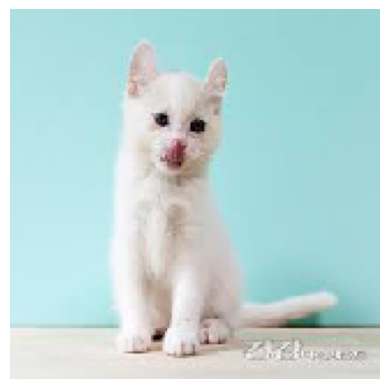

In [57]:
show_and_predict_image('/content/drive/MyDrive/Colab Notebooks/aiffel/','cat.jpg')

- 고양이 얼굴 모양이 애매하다 싶은 이미지를 가져 왔는데 , 정확하게 구분이 안되는 것 같다. 솔직히 얘기해서 꼬리를 보기전에는 바로 판단이 안선다.

1/1 [==============================] - 0s 19ms/step
This image seems 0% dog, and 100% cat.


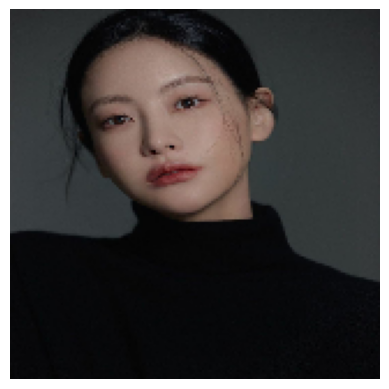

In [58]:
show_and_predict_image('/content/drive/MyDrive/Colab Notebooks/aiffel/','1.jpg')

1/1 [==============================] - 0s 29ms/step
This image seems 100% dog, and 0% cat.


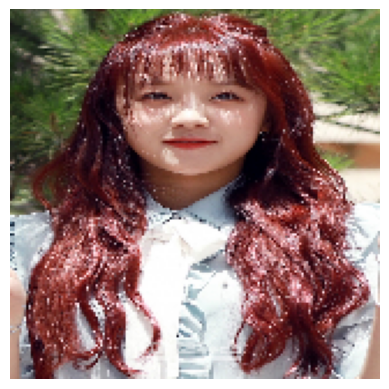

In [59]:
show_and_predict_image('/content/drive/MyDrive/Colab Notebooks/aiffel/','2.jpg')

- 1번은 고양이상의 이미지를 검색 , 2번은 강아지상의 이미지를 검색 해서 분류를 해 봤는데 정확하게 구분을 하고 있다.. 나는 잘 모르겠지만 특성이 있는 건가 ?? 잘 모르겠다..